In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#Be careful for set path
cur_path = os.getcwd()
print(cur_path)
q_star_arr = [ "100", "300", "500", "700", "900", "1100", "1300", "1500" ]

C:\Users\jeong\Desktop\tutorial\AFPs\Tm\sparse_sampling\continuous\chillplus


In [2]:
#Get q values for each simulation and save it as numpy array. Data is a list collecting all numpy arrays.
q_arr = []

for i in q_star_arr:
    work_path = cur_path + "\\" +i
    print(work_path)
    os.chdir(work_path)
    
    file = 'TM_'+i+'_monitor.dat'
    q = np.array(pd.read_csv(file, sep='\t|  ',engine='python'))
    print(q.shape)
    
    if np.int(i) < 800:
        q_arr += [q[75000:,1]]
    else:
        q_arr += [q[25000:,1]]

q_arr = np.array(q_arr)

    

C:\Users\jeong\Desktop\tutorial\AFPs\Tm\sparse_sampling\continuous\chillplus\100
(100001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\sparse_sampling\continuous\chillplus\300
(100001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\sparse_sampling\continuous\chillplus\500
(100001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\sparse_sampling\continuous\chillplus\700
(100001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\sparse_sampling\continuous\chillplus\900
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\sparse_sampling\continuous\chillplus\1100
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\sparse_sampling\continuous\chillplus\1300
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\sparse_sampling\continuous\chillplus\1500
(50001, 7)


In [4]:
# This code is writting by Jeongmoon Choi
# email: jeongmoon2006@gmail.com

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

class sparse_sampling:
    '''
    Calculates free energy using sparse sampling
    
    Energy has three terms. 
    1. first energy: density probability of bias simulation
    2. second energy: applied harmonic potential 
    3. third energy: thermodynamic integration
    
    Args:
      q_star_arr(numpy.ndarray): q* matrix (N,)
      q_arr(numpy.ndarray): q matrix (simulation #, time #)
      n_bins(int): The number of bins that the probability should bin
      kappa(float): harmonic bias spring constant in kJ/mol
    '''
    
    
    def __init__(self, q_star_arr, q_arr, n_bins, kappa):
        
        self.q_star_arr = q_star_arr
        self.q_arr = q_arr
        self.n_bins = n_bins
        self.kappa = kappa
        
        #number of simulations
        self.n_simulation = q_arr.shape[0]
        
        #number of time frames for each simulation
        self.n_time = q_arr.shape[1]
        
        #average q value for each simulation
        self.average_q = []
        for i in range(self.n_simulation):
            self.average_q += [np.average(q_arr[i])]
        self.average_q = np.array(self.average_q)
        
    
    def first_energy(self, plot = True):
        
        '''
        Return:
           1. bins(numpy.ndarray): collection of bins for each simulation (simulation #, n_bins)
           2. prob(numpy.ndarray): collection of probability for each simulation (simulation #, n_bins)
           3. first_energy(numpy.ndarray): first energy for each simulation without unit(simulation #,)
        '''
        
        bins = []
        prob = []
        
        for i in range(self.n_simulation):
            q = self.q_arr[i]
            min_ = np.min(q)
            max_ = np.max(q)
            bins_ = np.linspace(min_, max_, self.n_bins)
            
            digitized = np.digitize(q, bins_, right = True)
            prob_ = (np.array([(digitized == i).sum() for i in range(0,self.n_bins)])+1)/ self.n_time
            
            bins += [bins_]
            prob += [prob_]
            
        bins = np.array(bins)
        prob = np.array(prob)
        
        first_energy = []
        for i in range(self.n_simulation):
            first_energy += [-np.log(np.max(prob[i]))]
        first_energy = np.array(first_energy)
        
        
        #make plot
        if plot:
            figure(figsize=(8, 6), dpi=200)

            for i in range(bins.shape[0]):
                plt.plot(bins[i], -np.log(prob[i]), marker = 'o')

            plt.legend(q_star_arr, bbox_to_anchor=(1.01, 1.05))    
            plt.xlabel(r'$\tilde{q}$', fontsize=15)
            plt.ylabel(r'$\beta F_v^{harm}(\tilde{q})$', fontsize=15)
        
        
        return bins, prob, first_energy
    
    
    
    def second_energy(self,temperature = 298, plot = True):
        
        '''
        Return:
           1. average_q(numpy.ndarray): average q value for each simulation (simulation #,)
           2. second_energy(numpy.ndarray): second energy term without unit (simulation #,)
        '''
        
        second_energy = []
        
        for i in range(self.n_simulation):
            q_diff = self.average_q[i] - np.float(self.q_star_arr[i])
            beta_T = 1/8.314/temperature*1000
            second_energy += [0.5*self.kappa*np.power(q_diff,2)*beta_T]
            
        second_energy = np.array(second_energy)
        
        #plot
        if plot:
            figure(figsize=(8, 6), dpi=200)
            plt.plot(self.average_q, second_energy, marker = 'o')
            plt.xlabel(r'$\tilde{q}$', fontsize=15)
            plt.ylabel(r'$\beta U_{v}^{harm}$', fontsize=15)
        
        return self.average_q, second_energy
    

    
    def third_energy(self,temperature = 298, plot = True):
        
        '''
        Return:
           1. q_star_arr(numpy.ndarray): q star value for each simulation (simulation #,)
           2. third_energy(numpy.ndarray): third energy term without unit (simulation #,)
        '''      
        
        
        #Calculate integrand
        dfdq_star=[]

        for i in range(self.n_simulation):
            q_diff = -(self.average_q[i]-np.float(self.q_star_arr[i]))
            beta_T = 1/8.314/temperature*1000
            dfdq_star+=[0.01*q_diff*beta_T]

        dfdq_star=np.array(dfdq_star)

        #make a plot
        if plot:
            figure(figsize=(8, 6), dpi=200)
            plt.plot(self.q_star_arr, dfdq_star, marker = 'o')
            plt.xlabel(r'$q*$', fontsize=15)
            plt.ylabel(r'$\beta \partial F_{q*}/ \partial q*$', fontsize=15)
        
        
        
        #Get integral
        #make the first term 0. Note that it is integral. I should have reference value, in this case the value would be 0
        third_energy=[]
        third_energy+=[0]
        for i in range(self.n_simulation -1):
            third_energy += [(np.float(self.q_star_arr[i+1]) - np.float(self.q_star_arr[i]))*(dfdq_star[i+1] + dfdq_star[i])/2 + np.float(third_energy[i])]
        third_energy=np.array(third_energy)

        #make a plot
        if plot:
            figure(figsize=(8, 6), dpi=200)
            plt.plot(self.q_star_arr, third_energy, marker = 'o')
            plt.xlabel(r'$q*$', fontsize=15)
            plt.ylabel(r'$\beta F_{harm} (q*)$', fontsize=15)
        
        return self.q_star_arr, third_energy
    
    
    def free_energy(self, temperature = 298, plot = False):
        
        '''
        Return:
           1. q_star_arr(numpy.ndarray): q star value for each simulation (simulation #,)
           2. free_energy(numpy.ndarray): free energy term without unit (simulation #,)
           3. driving_force(numpy.ndarray): driving force term without unit (simulation # -1,)
        '''      
        
        _, _, first = self.first_energy(plot)
        _, second = self.second_energy(temperature, plot)
        _, third = self.third_energy(temperature, plot)
        
        figure(figsize=(8, 6), dpi=200)
        free_energy = first - second + third
        min_e = np.min(free_energy)
        #set starting free energy as 0
        free_energy = free_energy - min_e
        
        figure(figsize=(8, 6), dpi=200)
        plt.plot(self.average_q, free_energy, marker = 'o')
        plt.xlabel(r'$\tilde {q}$', fontsize=15)
        plt.ylabel(r'$\beta F_{v} (\tilde {q})$', fontsize=15)
        
        
        #Get driving force by differentiating the free energy
        diff_average_q = np.array([self.average_q[i+1]- self.average_q[i] for i in range(np.shape(self.average_q)[0]-1)])
        diff_energy = np.array([free_energy[i+1]- free_energy[i] for i in range(np.shape(self.average_q)[0]-1)])
        driving_force = diff_energy/diff_average_q

        figure(figsize=(8, 6), dpi=200)
        plt.plot(self.average_q[:-1], driving_force, marker = 'o')
        plt.xlabel(r'$\tilde {q}$', fontsize=15)
        plt.ylabel(r'$\beta \partial F_{v}/\partial \tilde {q}$', fontsize=15)
        
        
        
        return self.q_arr, free_energy, driving_force
    


In [5]:
aa = sparse_sampling(q_star_arr, q_arr, 50, 0.01)

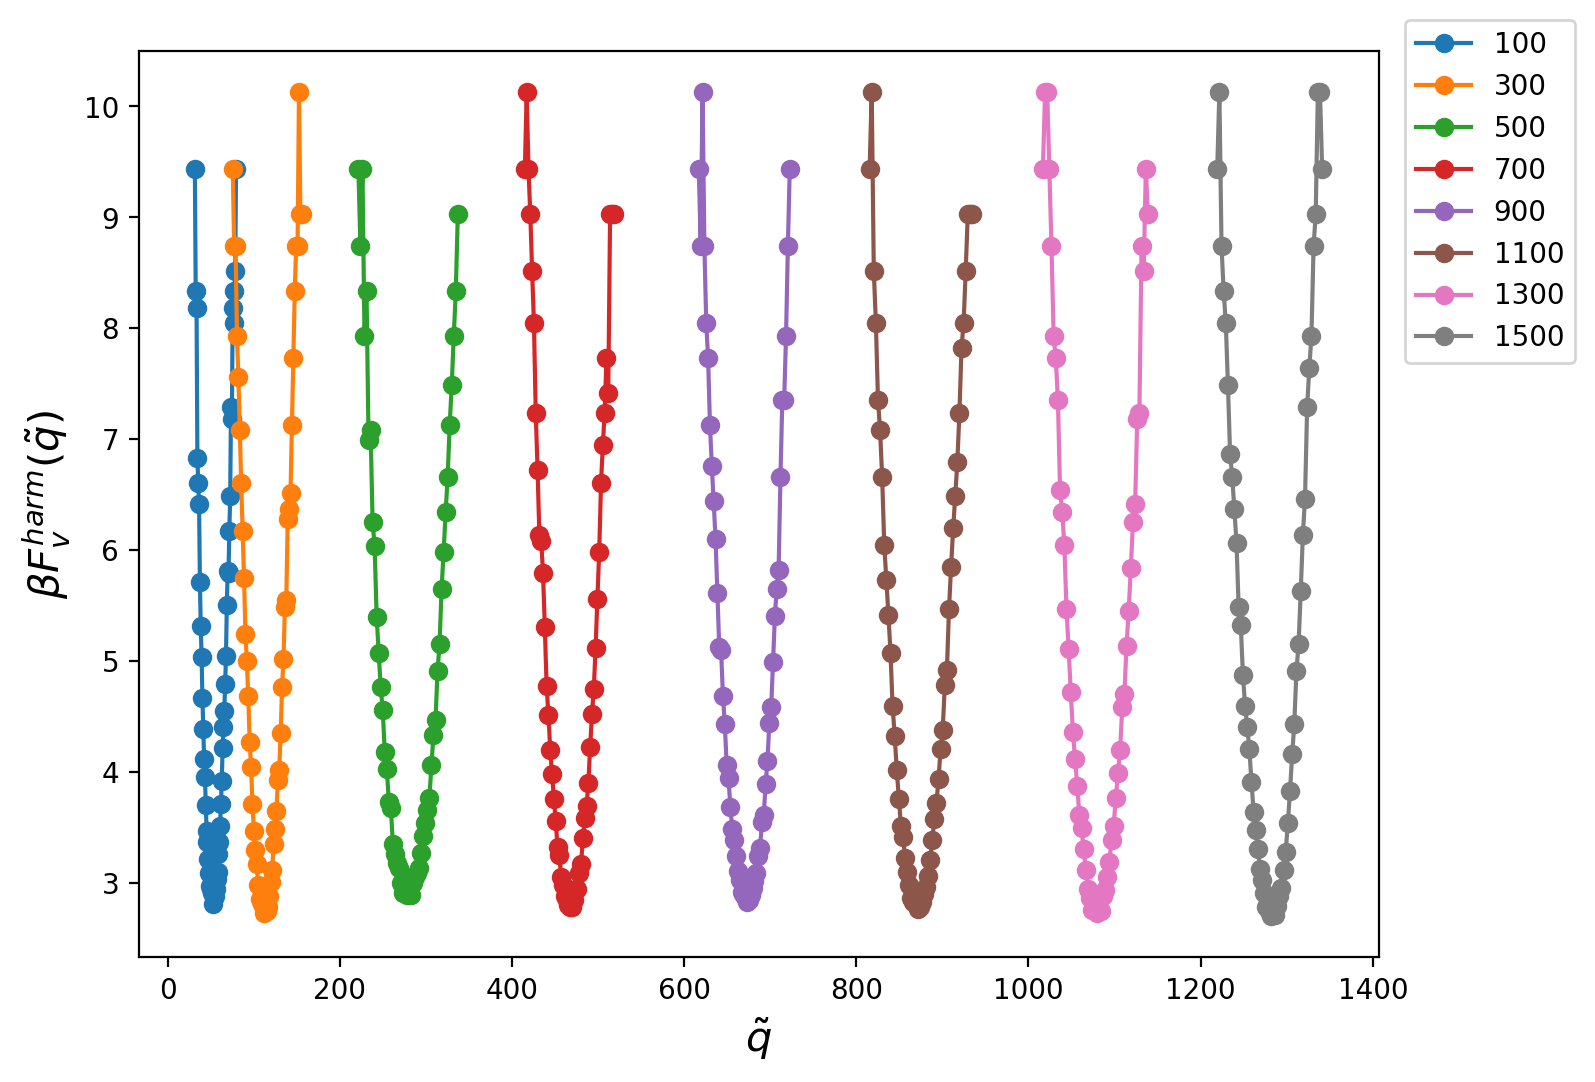

In [6]:
pro, binss, first_e = aa.first_energy()

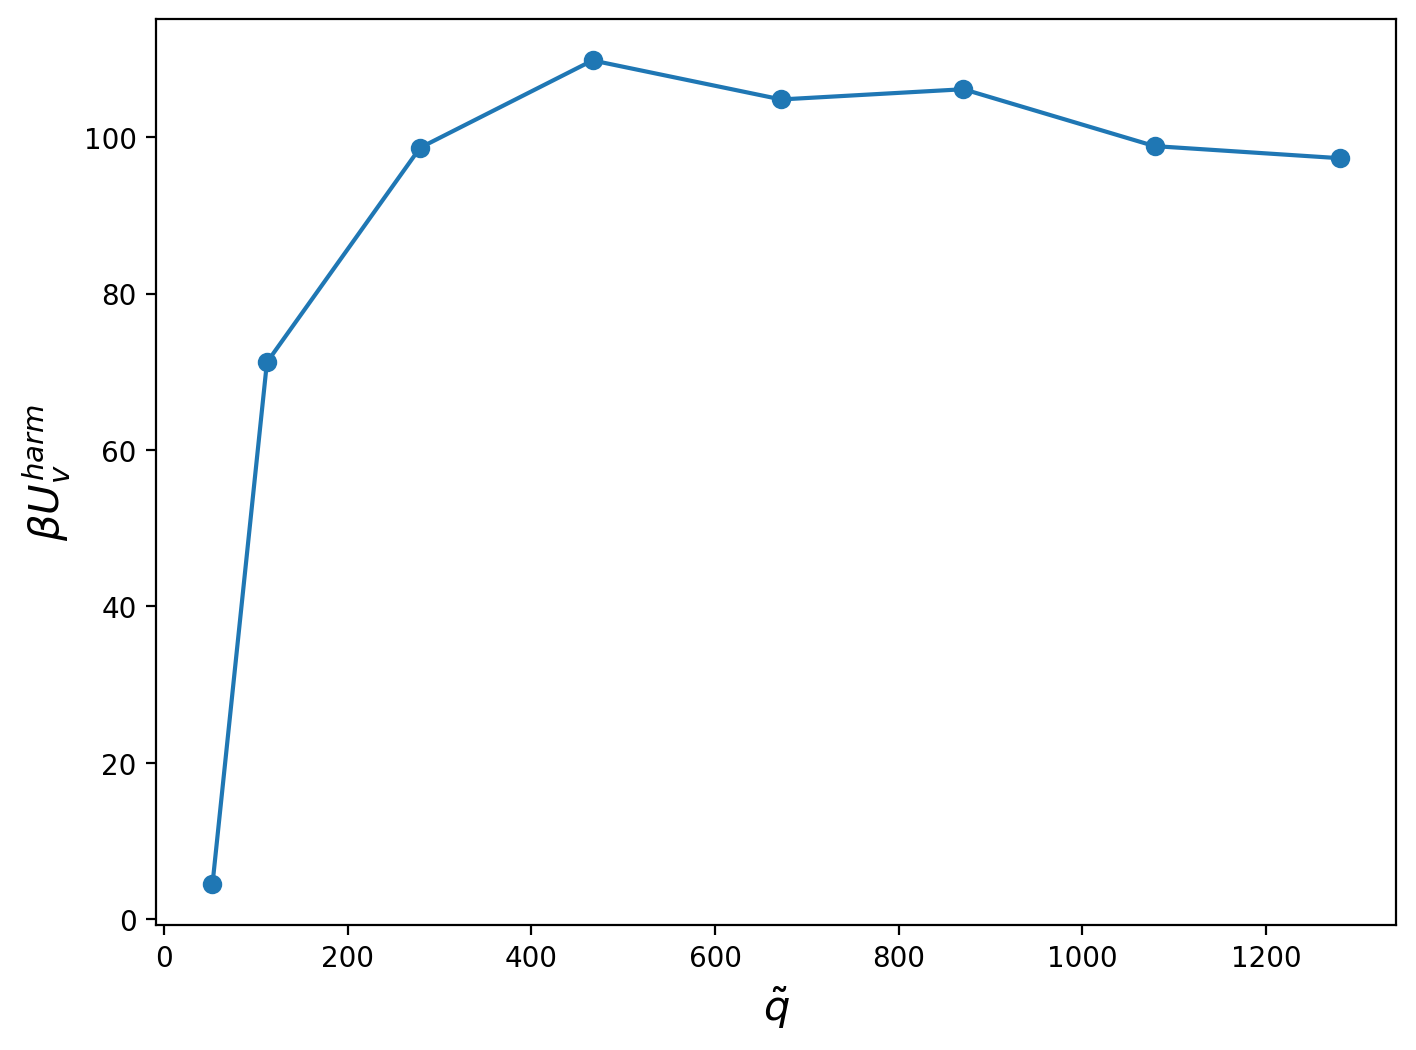

In [7]:
average_q, second = aa.second_energy()

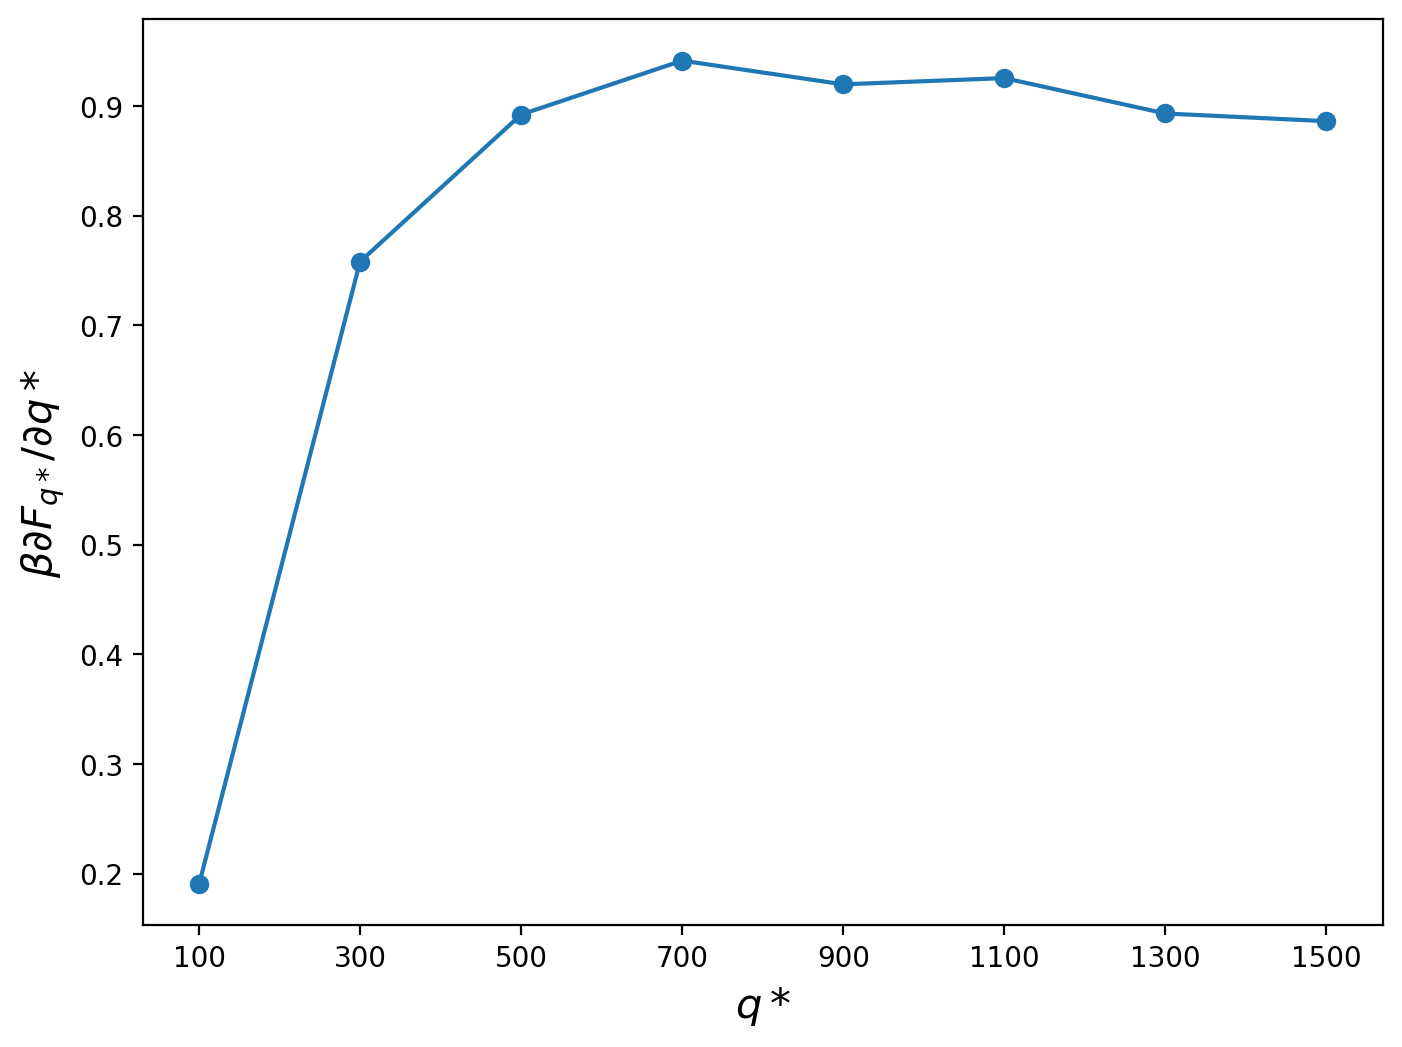

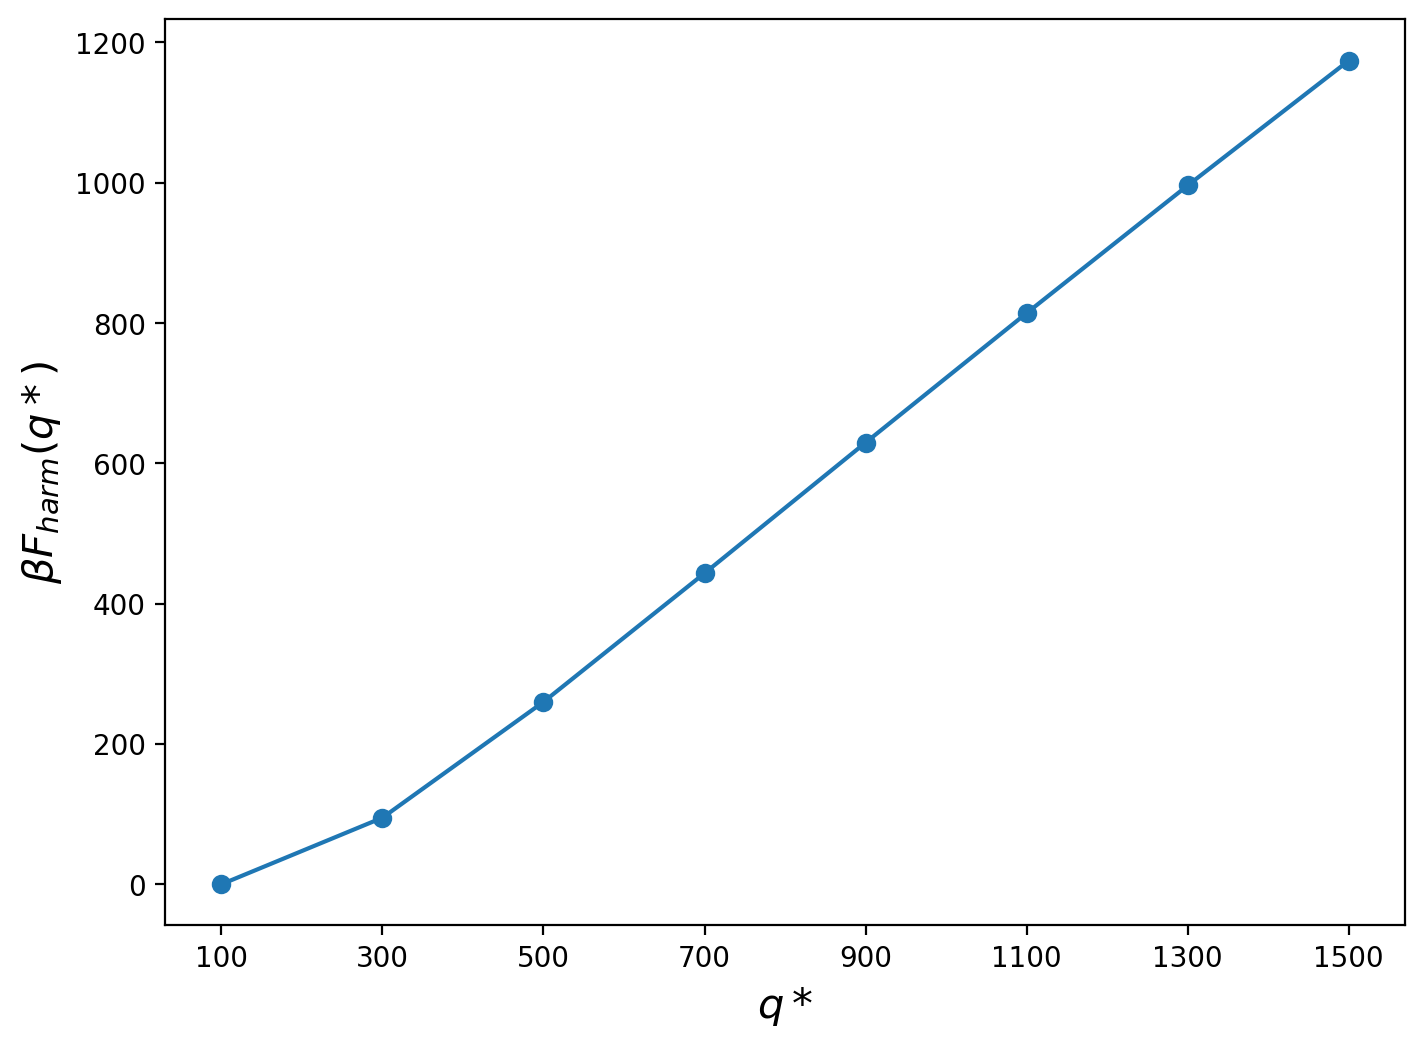

In [8]:
qstar, third = aa.third_energy()

<Figure size 1600x1200 with 0 Axes>

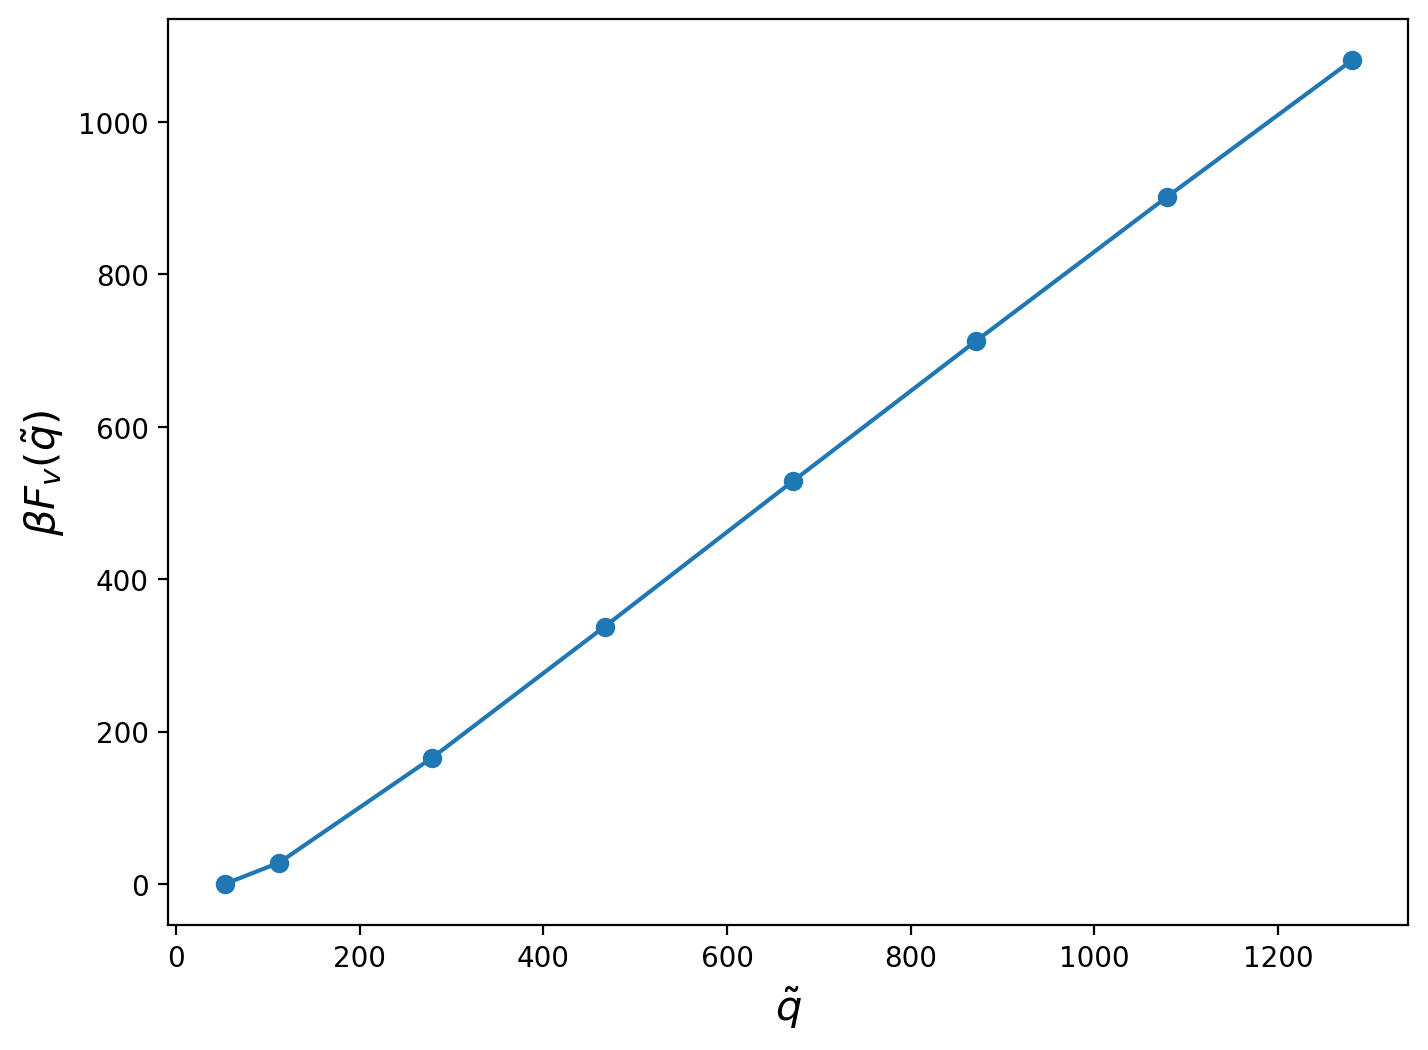

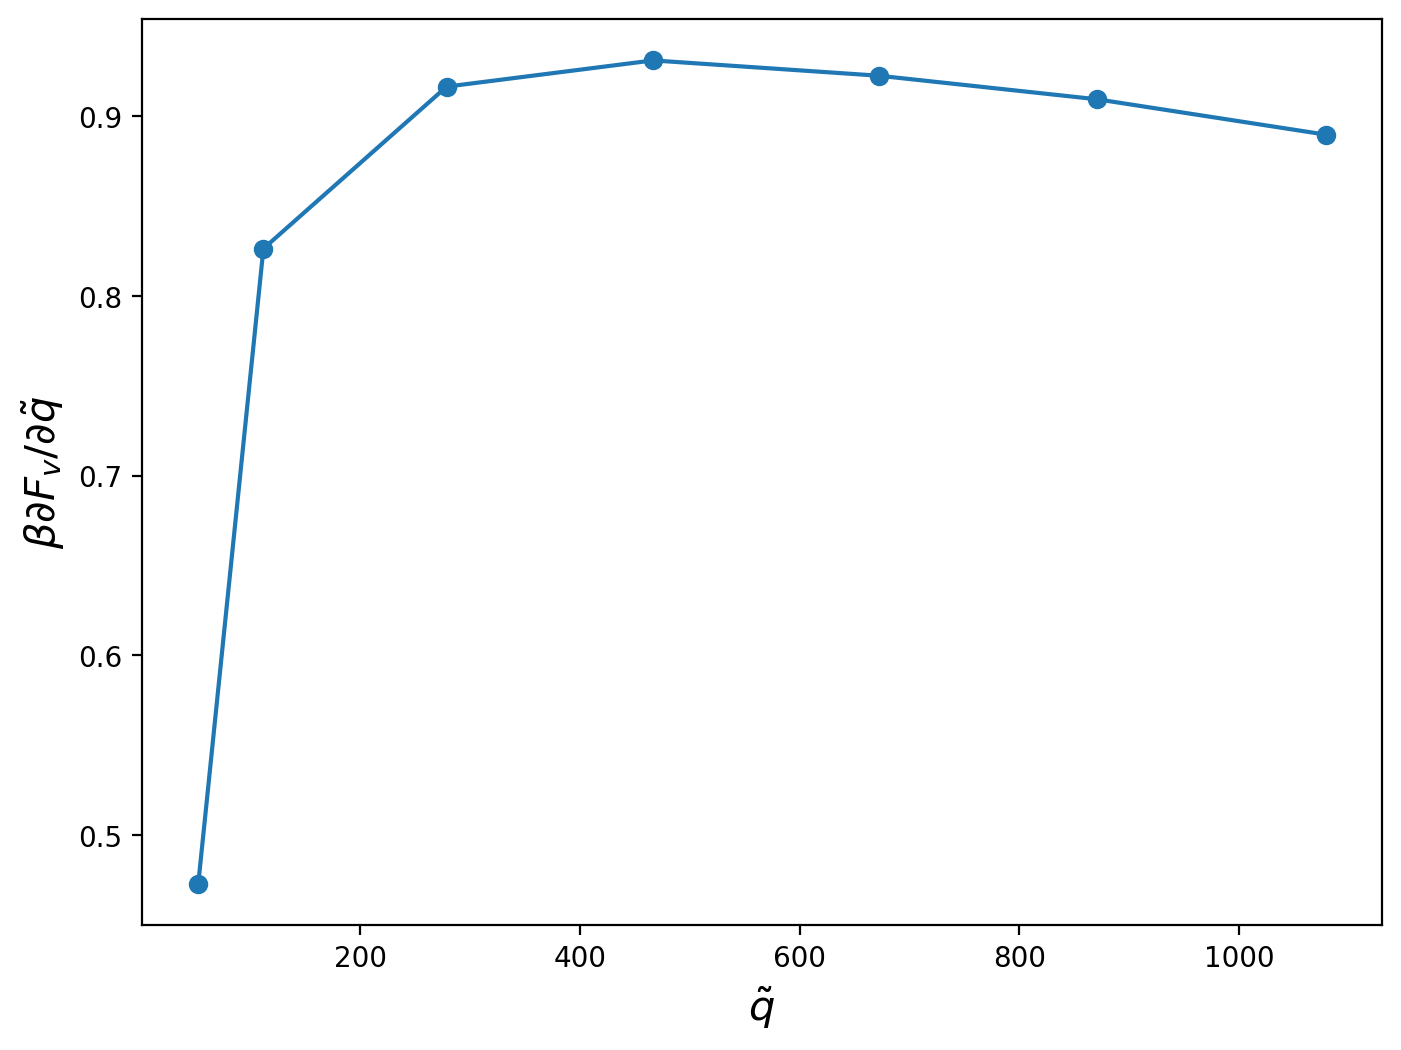

In [9]:
aq, free, driving = aa.free_energy()